In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.sql import functions as F
from scipy.stats import f_oneway
import random
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.window import Window
from pyspark.ml.regression import LinearRegression
from sklearn.metrics import mean_absolute_error as mae

# Create a spark session
spark = (
    SparkSession.builder.appName("analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "6g")
    .getOrCreate()
)

22/10/14 17:12:20 WARN Utils: Your hostname, DESKTOP-LNDD2A2 resolves to a loopback address: 127.0.1.1; using 172.21.134.174 instead (on interface eth0)
22/10/14 17:12:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/14 17:12:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/14 17:12:28 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/14 17:12:28 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/10/14 17:12:28 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


# Model 3: Unique Middle Income Customers

The thresholds defined below are based from [a survey on BNPL usage](https://www.bankrate.com/loans/personal-loans/buy-now-pay-later-statistics/)

In [2]:
LOWER_INCOME_THRESHOLD = 50000
UPPER_INCOME_THRESHOLD = 75000

In [3]:
# Load final dataset
finaldf = spark.read.parquet("../data/curated/finaldf.parquet/")
finaldf.limit(5)

order_datetime,merchant_abn,user_id,postcode,consumer_id,dollar_value,order_id,state,gender,company_name,tags,take_rate,revenue_band,total_pop,under10_pop,adolsc_pop,yng_adult_pop,mid_age_pop,old_pop,num_earners,median_age,median_income,mean_income,consumer_fraud_%,merchant_fraud_%
2021-08-21,80682333501,3146,5651,604753,0.3672339667473312,2a59c978-f760-42d...,SA,Male,Orci Corp.,florists supplies...,4.88,b,2172,275,278,304,692,623,1308,47,37685,43540,0.1,0.1
2021-08-19,99478391356,3146,5651,604753,3035.1695642706595,82e100bc-25c2-4e3...,SA,Male,Orci Quis Foundation,"equipment, tool, ...",1.52,c,2172,275,278,304,692,623,1308,47,37685,43540,0.1,0.1
2021-08-19,86578477987,3146,5651,604753,61.05946896765003,9e3c8e62-9e8e-4e8...,SA,Male,Leo In Consulting,"watch, clock, and...",6.43,a,2172,275,278,304,692,623,1308,47,37685,43540,0.1,0.1
2021-08-14,32361057556,3146,5651,604753,155.3456409871304,e4ff9499-e96d-4e6...,SA,Male,Orci In Consequat...,"gift, card, novel...",6.61,a,2172,275,278,304,692,623,1308,47,37685,43540,0.1,0.1
2021-08-16,20445424481,3146,5651,604753,57.66971365811276,4a36f2ed-7bcc-43d...,SA,Male,Amet Industries,digital goods: bo...,6.29,a,2172,275,278,304,692,623,1308,47,37685,43540,0.1,0.1


Extract the year and month from the order datetime into a seperate column, we will use these to both group the dataset and create a new feature int_month. We also create a feature indicating whether the transaction has been made by a customer who resides in a postcode with median income in the range defined above.

In [4]:
modeldf = finaldf.withColumn("year", date_format(col("order_datetime"), "yyyy").cast("long"))
modeldf = modeldf.withColumn("month", date_format(col("order_datetime"), "MM").cast("long"))
modeldf = modeldf.filter((modeldf.median_income > LOWER_INCOME_THRESHOLD) &
                         (modeldf.median_income < UPPER_INCOME_THRESHOLD))
modeldf.limit(5)

22/10/14 17:13:02 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


order_datetime,merchant_abn,user_id,postcode,consumer_id,dollar_value,order_id,state,gender,company_name,tags,take_rate,revenue_band,total_pop,under10_pop,adolsc_pop,yng_adult_pop,mid_age_pop,old_pop,num_earners,median_age,median_income,mean_income,consumer_fraud_%,merchant_fraud_%,year,month
2021-08-21,74046727484,7064,3197,841590,83.72597094904893,61f2988d-709b-46f...,VIC,Female,Vestibulum Accums...,"gift, card, novel...",5.10,b,12115,1392,1291,1898,4304,3230,7302,46,54598,68945,0.1,0.1,2021,8
2021-08-19,34822634769,7064,3197,841590,89.4559409155605,9654ebba-51fa-4a7...,VIC,Female,Dolor Egestas Rho...,"cable, satellite,...",0.71,d,12115,1392,1291,1898,4304,3230,7302,46,54598,68945,0.1,0.1,2021,8
2021-08-22,96680767841,7064,3197,841590,196.16668339788086,149406fa-e7b1-479...,VIC,Female,Ornare Limited,motor vehicle sup...,5.91,a,12115,1392,1291,1898,4304,3230,7302,46,54598,68945,0.1,0.1,2021,8
2021-08-15,80324045558,7064,3197,841590,62.30980676808807,231df649-21d4-4cd...,VIC,Female,Ipsum Dolor Sit C...,"gift, card, novel...",1.47,c,12115,1392,1291,1898,4304,3230,7302,46,54598,68945,0.1,0.1,2021,8
2021-07-15,45663905997,7064,3197,841590,216.90848569313803,2d8fdb5d-6447-46e...,VIC,Female,Lacus Mauris Asso...,shoe shops,0.48,e,12115,1392,1291,1898,4304,3230,7302,46,54598,68945,0.1,0.1,2021,7


In [5]:
# Get monthly middle customers feature
modeldf = modeldf.groupBy("year","month","merchant_abn").agg(
    countDistinct("consumer_id").alias("monthly_middle_customers"),
)

In [6]:
# Turn year and month into field 'int_month'
MONTHS = 12
modeldf = modeldf.withColumn('int_month', MONTHS*(modeldf['year'] - 2021) + (modeldf['month'] - 1))
modeldf = modeldf.drop('year', 'month')
modeldf

merchant_abn,monthly_middle_customers,int_month
94472466107,300,16
16165222459,27,15
60956456424,1107,16
82539239304,24,16
53655334735,7,10
33163130598,34,2
24852446429,2818,9
31585975447,191,3
46987545043,245,20
52160665475,162,15


If any of the valid merchant_abns from the final dataset do not have any transactions listed in the dataset, we will need to manually add a row stating this month had 0 monthly middle customers.

In [7]:
# Get all valid merchant abns
merchant_abns = finaldf.select('merchant_abn').distinct().toPandas()['merchant_abn']

# Originally set all merchant abns to have 0 transactions every month
records = []
for m in merchant_abns:
    for int_month in range(1, 22):
        records.append([m, 0, int_month])        
defaultdf = spark.createDataFrame(records, 
                                  schema=['merchant_abn', 'monthly_middle_customers_0', 'int_month'])

# Now overwrite the values that are present in modeldf.
modeldf = defaultdf.join(modeldf, on=['merchant_abn', 'int_month'], how='left')
modeldf = modeldf.drop('monthly_middle_customers_0')
modeldf = modeldf.na.fill(value=0,subset=["monthly_middle_customers"])

In [8]:
modeldf.sort('merchant_abn', 'int_month').show(60)

+------------+---------+------------------------+
|merchant_abn|int_month|monthly_middle_customers|
+------------+---------+------------------------+
| 10023283211|        1|                       1|
| 10023283211|        2|                      22|
| 10023283211|        3|                      35|
| 10023283211|        4|                      38|
| 10023283211|        5|                      44|
| 10023283211|        6|                      44|
| 10023283211|        7|                      38|
| 10023283211|        8|                      37|
| 10023283211|        9|                      45|
| 10023283211|       10|                      50|
| 10023283211|       11|                      54|
| 10023283211|       12|                      31|
| 10023283211|       13|                      35|
| 10023283211|       14|                      41|
| 10023283211|       15|                      37|
| 10023283211|       16|                      53|
| 10023283211|       17|                      41|


To determine the number of lags that are used, we build autocorrelation plots to determine the correlation between lags of the  monthly middle customers feature. Note that these plots need to be created for an individual merchant, hence the code below chooses 5 random merchants (can uncomment the setting of the seed for this to becompletely randomised), and builds autocorrelation plots.

In [9]:
df = modeldf.toPandas()

In [10]:
# Perform one hot encoding on merchant abn so that it is treated as categorical in model
one_hot = pd.get_dummies(df['merchant_abn'])
df = df.join(one_hot)
df 

,merchant_abn,int_month,monthly_middle_customers,10023283211,10142254217,10165489824,10187291046,10192359162,10206519221,10255988167,...,99803748393,99807059634,99845294286,99861963809,99904689266,99938978285,99974311662,99976658299,99987905597,99990536339
0,38700038932,11,101,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,35344855546,19,20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,78916025936,13,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,60654402457,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,37470904997,14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84373,72064300998,5,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84374,29623808496,21,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84375,47047735645,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84376,39700611505,15,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


26482181417


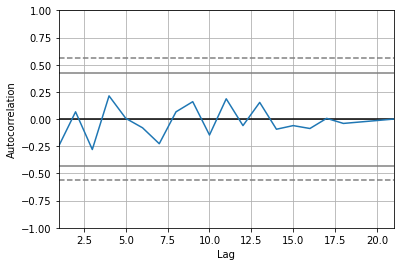

67797658023


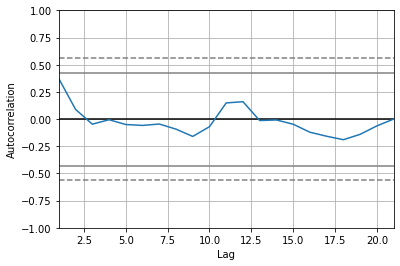

14480530534


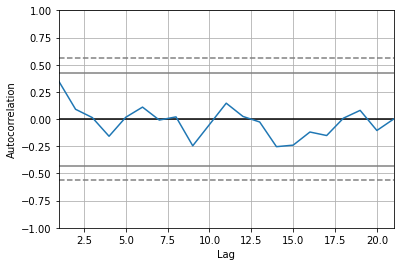

67979471799


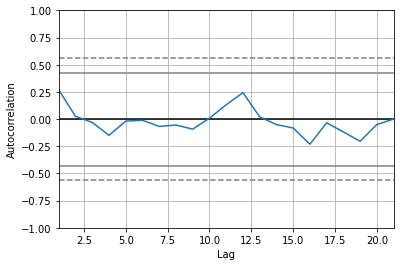

31686734877


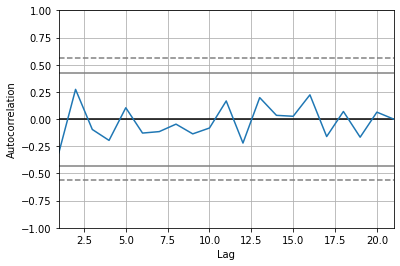

In [11]:
# We plot the autocorrelation for 5 random merchants
random.seed(4302022)

for i in range(5):
    random_merchant = random.sample(merchant_abns.tolist(), 1)[0]
    
    print(random_merchant)
    
    filtereddf = df[df[random_merchant] == 1][['int_month', 'monthly_middle_customers']]
    filtereddf = filtereddf.sort_values('int_month')
    filtereddf = filtereddf['monthly_middle_customers']
    
    x = pd.plotting.autocorrelation_plot(filtereddf)
 
    x.plot()
 
    plt.show()

For the reasons outlined in notebook 4.1, as well as for the sake of consistency, we again utilise 2 lags for this model.

In [12]:
# Create new field merchant_abn_class, a number between 0-4017 representing a single merchant_abn 
indexer = StringIndexer(inputCol='merchant_abn', outputCol='merchant_abn_class')
indexer_fitted = indexer.fit(modeldf)
modeldf = indexer_fitted.transform(modeldf)
modeldf

merchant_abn,int_month,monthly_middle_customers,merchant_abn_class
38700038932,11,101,1327.0
35344855546,19,20,1181.0
78916025936,13,1,3108.0
60654402457,5,0,2279.0
37470904997,14,0,1270.0
61867784114,3,2,2323.0
46331355995,7,30,1668.0
35927874515,2,39,1214.0
57093429717,20,16,2145.0
14316652139,8,2,190.0


In [13]:
# Complete one hot encoding of merchant_abn
encoder = OneHotEncoder(inputCols=['merchant_abn_class'], outputCols=['merchant_abn_ohe'])
modeldf = encoder.fit(modeldf).transform(modeldf)
modeldf

merchant_abn,int_month,monthly_middle_customers,merchant_abn_class,merchant_abn_ohe
38700038932,11,101,1327.0,"(4017,[1327],[1.0])"
35344855546,19,20,1181.0,"(4017,[1181],[1.0])"
78916025936,13,1,3108.0,"(4017,[3108],[1.0])"
60654402457,5,0,2279.0,"(4017,[2279],[1.0])"
37470904997,14,0,1270.0,"(4017,[1270],[1.0])"
61867784114,3,2,2323.0,"(4017,[2323],[1.0])"
46331355995,7,30,1668.0,"(4017,[1668],[1.0])"
35927874515,2,39,1214.0,"(4017,[1214],[1.0])"
57093429717,20,16,2145.0,"(4017,[2145],[1.0])"
14316652139,8,2,190.0,"(4017,[190],[1.0])"


In [14]:
# Create the lagged variables
partition = Window.partitionBy("merchant_abn").orderBy("int_month")
modeldf = modeldf.withColumn('monthly_middle_customers-1', lag('monthly_middle_customers', 1).over(partition))
modeldf = modeldf.withColumn('monthly_middle_customers-2', lag('monthly_middle_customers', 2).over(partition))
modeldf.show(60)

+------------+---------+------------------------+------------------+----------------+--------------------------+--------------------------+
|merchant_abn|int_month|monthly_middle_customers|merchant_abn_class|merchant_abn_ohe|monthly_middle_customers-1|monthly_middle_customers-2|
+------------+---------+------------------------+------------------+----------------+--------------------------+--------------------------+
| 10023283211|        1|                       1|               0.0|(4017,[0],[1.0])|                      null|                      null|
| 10023283211|        2|                      22|               0.0|(4017,[0],[1.0])|                         1|                      null|
| 10023283211|        3|                      35|               0.0|(4017,[0],[1.0])|                        22|                         1|
| 10023283211|        4|                      38|               0.0|(4017,[0],[1.0])|                        35|                        22|
| 10023283211|      

In [15]:
# Remove the months without valid lagged variables
modeldf = modeldf.na.drop()
modeldf.count()

76342

Now we build our time series regression model, with our testing data being the final 3 months of the dataset.

In [16]:
SPLIT_MONTH = 18

# Prepare a features column for the model
vecAssembler = VectorAssembler(inputCols=['merchant_abn_ohe', 'int_month', 
                                          'monthly_middle_customers-1', 
                                          'monthly_middle_customers-2'], 
                               outputCol='features')

# Train test split
train = modeldf.filter(col('int_month') <= SPLIT_MONTH)
test = modeldf.filter(col('int_month') > SPLIT_MONTH)

# Apply transformation to both datasets
train = vecAssembler.transform(train)
test = vecAssembler.transform(test)
train

merchant_abn,int_month,monthly_middle_customers,merchant_abn_class,merchant_abn_ohe,monthly_middle_customers-1,monthly_middle_customers-2,features
10023283211,3,35,0.0,"(4017,[0],[1.0])",22,1,"(4020,[0,4017,401..."
10023283211,4,38,0.0,"(4017,[0],[1.0])",35,22,"(4020,[0,4017,401..."
10023283211,5,44,0.0,"(4017,[0],[1.0])",38,35,"(4020,[0,4017,401..."
10023283211,6,44,0.0,"(4017,[0],[1.0])",44,38,"(4020,[0,4017,401..."
10023283211,7,38,0.0,"(4017,[0],[1.0])",44,44,"(4020,[0,4017,401..."
10023283211,8,37,0.0,"(4017,[0],[1.0])",38,44,"(4020,[0,4017,401..."
10023283211,9,45,0.0,"(4017,[0],[1.0])",37,38,"(4020,[0,4017,401..."
10023283211,10,50,0.0,"(4017,[0],[1.0])",45,37,"(4020,[0,4017,401..."
10023283211,11,54,0.0,"(4017,[0],[1.0])",50,45,"(4020,[0,4017,401..."
10023283211,12,31,0.0,"(4017,[0],[1.0])",54,50,"(4020,[0,4017,401..."


In [17]:
# Train model
lr = LinearRegression(featuresCol='features', labelCol='monthly_middle_customers')
lrModel = lr.fit(train)

22/10/14 17:15:59 WARN Instrumentation: [b8293eb1] regParam is zero, which might cause numerical instability and overfitting.


22/10/14 17:16:00 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/14 17:16:00 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


22/10/14 17:16:01 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [18]:
# Predict values for test data to evaluate model 
predictions = lrModel.transform(test)
predictions

merchant_abn,int_month,monthly_middle_customers,merchant_abn_class,merchant_abn_ohe,monthly_middle_customers-1,monthly_middle_customers-2,features,prediction
10023283211,19,49,0.0,"(4017,[0],[1.0])",58,41,"(4020,[0,4017,401...",52.815537330623464
10023283211,20,55,0.0,"(4017,[0],[1.0])",49,58,"(4020,[0,4017,401...",48.10543339539202
10023283211,21,45,0.0,"(4017,[0],[1.0])",55,49,"(4020,[0,4017,401...",51.552494003042504
10142254217,19,55,1.0,"(4017,[1],[1.0])",42,38,"(4020,[1,4017,401...",42.108915457572564
10142254217,20,30,1.0,"(4017,[1],[1.0])",55,42,"(4020,[1,4017,401...",48.29611587264945
10142254217,21,56,1.0,"(4017,[1],[1.0])",30,55,"(4020,[1,4017,401...",36.231645449211875
10165489824,19,0,2.0,"(4017,[2],[1.0])",0,0,"(4020,[2,4017],[1...",2.070634103306093
10165489824,20,0,2.0,"(4017,[2],[1.0])",0,0,"(4020,[2,4017],[1...",2.314238115459751
10165489824,21,0,2.0,"(4017,[2],[1.0])",0,0,"(4020,[2,4017],[1...",2.5578421276134082
10187291046,19,6,3.0,"(4017,[3],[1.0])",4,3,"(4020,[3,4017,401...",6.07837382339766


22/10/14 17:17:04 WARN DAGScheduler: Broadcasting large task binary with size 1369.1 KiB


26482181417


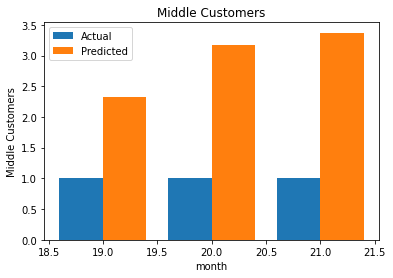

67797658023


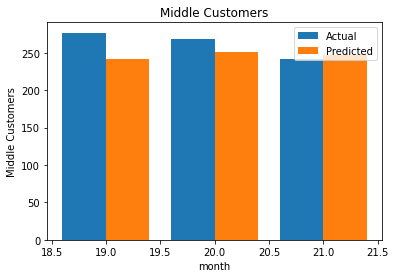

14480530534


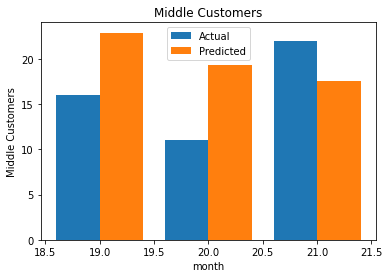

67979471799


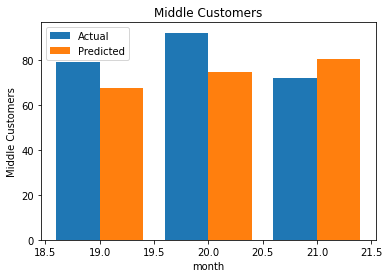

31686734877


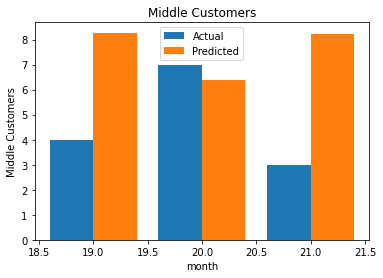

In [19]:
# Compare predictions and actual values for 5 random merchants
random.seed(4302022)

dfp = predictions.toPandas()
predictions.write.mode("overwrite").parquet("../data/curated/medium_customers_predictions.parquet")
X = [19, 20, 21]

for i in range(5):
    random_merchant = random.sample(merchant_abns.tolist(), 1)[0]
    print(random_merchant)
    X_axis = np.arange(19, 22)
    plt.bar(X_axis - 0.2, dfp[dfp['merchant_abn']==random_merchant]["monthly_middle_customers"], 0.4, label = 'Actual')
    plt.bar(X_axis + 0.2, dfp[dfp['merchant_abn']==random_merchant]["prediction"], 0.4, label = 'Predicted')
    plt.legend()
    plt.xlabel('month')
    plt.ylabel('Middle Customers')
    plt.title('Middle Customers')
    plt.show()

In [20]:
print(mae(dfp["monthly_middle_customers"],  dfp["prediction"]))

5.492855867887573


# Simulation

Build up predictions until we reach 2023. This needs to be done somewhat manually since we require previous predictions to then be used as lagged variables for the next months predictions. 

**Expect total run time of the following code to take several minutes.**

In [21]:
pdf = predictions.select('merchant_abn', 'int_month', 'prediction', 'merchant_abn_ohe').toPandas()
pdf

,merchant_abn,int_month,prediction,merchant_abn_ohe
0,10023283211,19,52.815537,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,10023283211,20,48.105433,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,10023283211,21,51.552494,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,10142254217,19,42.108915,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,10142254217,20,48.296116,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
12049,99987905597,20,4.387130,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12050,99987905597,21,5.999069,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12051,99990536339,19,2.746435,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12052,99990536339,20,2.947604,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [22]:
# We build predictions for every merchant, one month at a time 
records = []
for int_month in range(22, 36):
    merchant_data = []
    
    # Build up required information for this month's prediction for all merchants
    for m in merchant_abns:
        merchant_abn_ohe = pdf.loc[(pdf['merchant_abn']==m) & (pdf['int_month']==21), 'merchant_abn_ohe'].values[0]
        merchant_data.append([m, merchant_abn_ohe, int_month, 
                              float(pdf.loc[(pdf['merchant_abn']==m) & 
                                            (pdf['int_month']==(int_month-2)), 'prediction'].values[0]),
                              float(pdf.loc[(pdf['merchant_abn']==m) & 
                                            (pdf['int_month']==(int_month-1)), 'prediction'].values[0])])
    predictiondf = spark.createDataFrame(merchant_data, 
                                         schema=['merchant_abn', 'merchant_abn_ohe', 'int_month', 'monthly_middle_customers-1', 
                                                 'monthly_middle_customers-2'])
    
    # Now perform the predictions
    predictiondf = vecAssembler.transform(predictiondf)
    predictiondf = lrModel.transform(predictiondf)
    pdf = pd.concat([pdf, predictiondf.select('merchant_abn', 'int_month', 'prediction', 'merchant_abn_ohe').toPandas()])
    
    # Once we have reached 2023, start storing the predictions
    if int_month >= 24:
        for m in merchant_abns:
            records.append([2021 + (int_month//12), (int_month%12) + 1, m, 
                            float(pdf.loc[(pdf['merchant_abn']==m) & 
                                          (pdf['int_month']==(int_month)), 'prediction'].values[0])])

In [23]:
future_mcustomers_sdf = spark.createDataFrame(records, schema=['year', 'month', 'merchant_abn', 'total_middle_customers'])

future_mcustomers_sdf.write.mode("overwrite").parquet("../data/curated/futuremcustomers.parquet/")